# EE 519 — Time-domain Analysis of speech (Notebook 2)
## Time-Domain Features: Short-Time Energy, Magnitude, and Zero Crossing Rate (ZCR)

### Goals
By the end of this notebook, you will be able to:
1. Compute **short-time energy** and **short-time magnitude** over frames.
2. Interpret feature contours for **silence**, **voiced**, and **unvoiced** regions.
3. Compute **zero crossing rate (ZCR)** and understand when it works and when it fails.
4. Demonstrate practical issues: **noise** and **DC offset**, and simple fixes (mean removal).

### Inputs
- A WAV file (recommended: the same one used in Notebook 1)
- Optional: your own recording from Notebook 0

> This notebook assumes you already understand framing + windowing from Notebook 1.


---
## 0) Setup
We’ll re-use a few helper utilities and implement feature functions.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, display

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["axes.grid"] = True

def to_mono(x):
    x = np.asarray(x)
    if x.ndim == 2:
        x = x.mean(axis=1)
    if np.issubdtype(x.dtype, np.integer):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
    return np.clip(x, -1.0, 1.0)

def remove_dc(x):
    return x - np.mean(x)

def play_audio(x, fs):
    display(Audio(x, rate=fs))

def plot_waveform(x, fs, title="Waveform", tlim=None):
    t = np.arange(len(x)) / fs
    plt.figure()
    plt.plot(t, x, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    plt.show()

def frame_signal(x, N, H):
    L = len(x)
    if L < N:
        return np.zeros((0, N), dtype=np.float32)
    M = 1 + (L - N) // H
    frames = np.zeros((M, N), dtype=np.float32)
    for m in range(M):
        start = m * H
        frames[m] = x[start:start+N]
    return frames

def hamming_window(N):
    return np.hamming(N).astype(np.float32)

---
## 1) Load a speech signal
Set `wav_path` to your WAV. If you recorded something in Notebook 0, you can load that WAV here.


Loaded: speech.wav
Sampling rate (Hz): 16000
Duration (s): 4.0


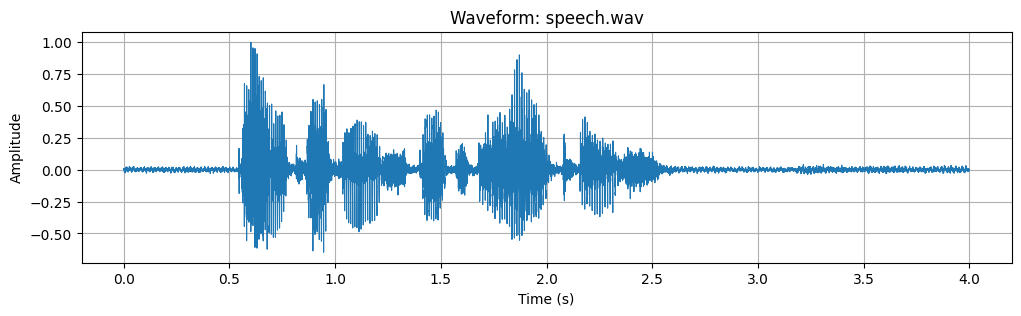

In [2]:
wav_path = "speech.wav"  # <- change as needed

if not os.path.exists(wav_path):
    print(f"File not found: {wav_path}\nUpload a WAV and update wav_path.")
else:
    fs, x = wavfile.read(wav_path)
    x = to_mono(x)
    print("Loaded:", wav_path)
    print("Sampling rate (Hz):", fs)
    print("Duration (s):", len(x)/fs)
    play_audio(x, fs)
    plot_waveform(x, fs, title=f"Waveform: {wav_path}")

---
## 2) Framing parameters
We’ll use a typical short-time analysis configuration.

- Frame length: 25 ms
- Hop size: 10 ms
- Window: Hamming


In [10]:
frame_ms = 25.0
hop_ms = 10.0

# frame_ms = 10.0
# hop_ms = 5.0

# frame_ms = 40.0
# hop_ms = 20.0

if "x" in globals():
    N = int(round(frame_ms * 1e-3 * fs))
    H = int(round(hop_ms   * 1e-3 * fs))
    w = hamming_window(N)
    frames = frame_signal(x, N, H)
    print(f"N={N} samples ({frame_ms} ms), H={H} samples ({hop_ms} ms)")
    print("Frames shape:", frames.shape)
else:
    print("Load audio first.")

N=400 samples (25.0 ms), H=160 samples (10.0 ms)
Frames shape: (398, 400)


---
## 3) Short-time Energy

### Definition
Given a windowed frame \(x_m[n] = x[n+mH]\.w[n]\), the short-time energy is
\[
E[m] = \sum_{n=0}^{N-1} (x_m[n])^2
\]

### Intuition
- Silence → very low energy
- Voiced vowels → high energy
- Unvoiced fricatives → moderate energy (often lower than vowels)


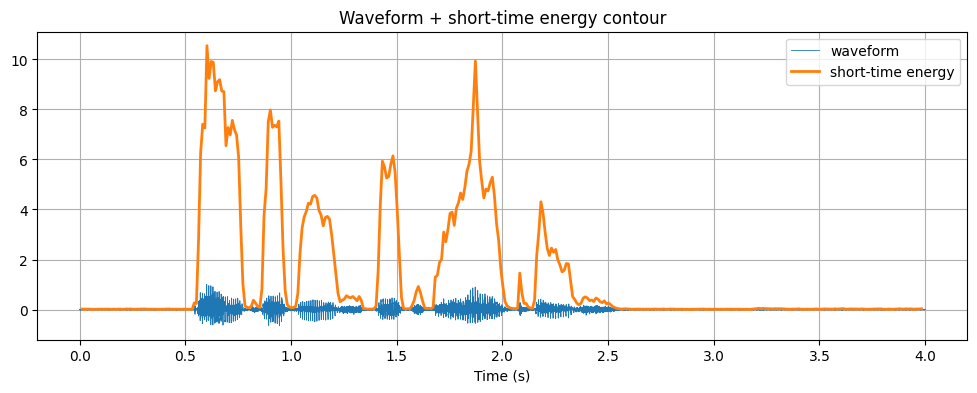

In [11]:
def short_time_energy(frames, w):
    # frames: (M, N), w: (N,)
    xw = frames * w[None, :]
    return np.sum(xw**2, axis=1)

def frame_times(M, N, H, fs):
    # frame center times
    return (np.arange(M)*H + N/2) / fs

if "frames" in globals():
    E = short_time_energy(frames, w)
    tE = frame_times(len(E), N, H, fs)

    plt.figure(figsize=(12, 4))
    t = np.arange(len(x)) / fs
    plt.plot(t, x, linewidth=0.6, label="waveform")
    plt.plot(tE, E, linewidth=2.0, label="short-time energy")
    plt.title("Waveform + short-time energy contour") 
    plt.xlabel("Time (s)")
    plt.legend()
    plt.show()

### Exercise: change frame length and hop size
Try:
- frame_ms = 10, hop_ms = 5
- frame_ms = 40, hop_ms = 20

Questions:
1. Which contour is smoother?
2. Which contour follows fast changes better?


### Answers

1. The 40,20 is smoother.
2. The 10,5 follow fast changes better.

---
## 4) Short-time Magnitude

### Definition
\[
M[m] = \sum_{n=0}^{N-1} |x_m[n]|
\]

### Intuition
Magnitude is often a bit less sensitive to large outliers than energy.


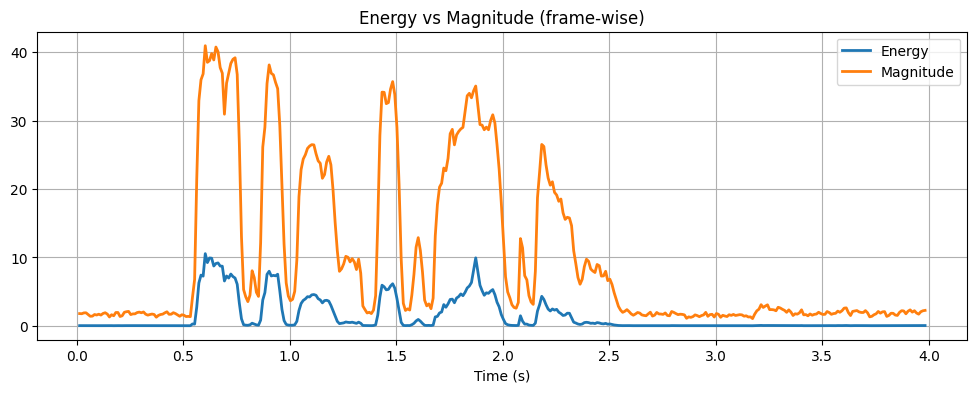

In [12]:
def short_time_magnitude(frames, w):
    xw = frames * w[None, :]
    return np.sum(np.abs(xw), axis=1)

if "frames" in globals():
    Mag = short_time_magnitude(frames, w)
    tM = frame_times(len(Mag), N, H, fs)

    plt.figure(figsize=(12, 4))
    plt.plot(tE, E, linewidth=2.0, label="Energy")
    plt.plot(tM, Mag, linewidth=2.0, label="Magnitude")
    plt.title("Energy vs Magnitude (frame-wise)")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.show()

---
## 5) Identify and compare regions: silence vs voiced vs unvoiced
Pick three short regions (in seconds) and compare the feature values.

> Tip: use regions that clearly look like silence / vowel / fricative.


In [13]:
# Edit these after looking at the waveform
regions = [
    ("Silence", 0.0, 0.5),
    ("Voiced vowel", 0.5, 0.75),
    ("Unvoiced fricative", 2.2, 2.5),
]

def region_stats(feature_t, feature, regions):
    for label, t0, t1 in regions:
        idx = np.where((feature_t >= t0) & (feature_t <= t1))[0]
        if len(idx) == 0:
            print(label, "-> no frames in region; adjust times") 
            continue
        vals = feature[idx]
        print(f"{label}: mean={np.mean(vals):.4e} | std={np.std(vals):.4e} | min={np.min(vals):.4e} | max={np.max(vals):.4e}")

print("Energy stats:")
region_stats(tE, E, regions)
print("\nMagnitude stats:")
region_stats(tM, Mag, regions)

Energy stats:
Silence: mean=1.4757e-02 | std=3.8012e-03 | min=7.1698e-03 | max=2.3327e-02
Voiced vowel: mean=6.0341e+00 | std=3.6622e+00 | min=8.8389e-03 | max=1.0548e+01
Unvoiced fricative: mean=1.0878e+00 | std=8.9369e-01 | min=1.8845e-01 | max=3.0839e+00

Magnitude stats:
Silence: mean=1.7083e+00 | std=2.0782e-01 | min=1.2499e+00 | max=2.0992e+00
Voiced vowel: mean=2.8651e+01 | std=1.5080e+01 | min=1.3282e+00 | max=4.0967e+01
Unvoiced fricative: mean=1.2644e+01 | std=5.4863e+00 | min=6.0735e+00 | max=2.3557e+01


---
## 6) Zero Crossing Rate (ZCR)

### Definition (conceptual)
ZCR counts the number of sign changes in a frame.

A common implementation is:
\[
Z[m] = \frac{1}{2N}\sum_{n=1}^{N-1} |\text{sgn}(x_m[n]) - \text{sgn}(x_m[n-1])|
\]

### Intuition
- Voiced vowel: low ZCR (periodic)
- Unvoiced fricative: high ZCR (noise-like)
- Silence: depends on background noise level


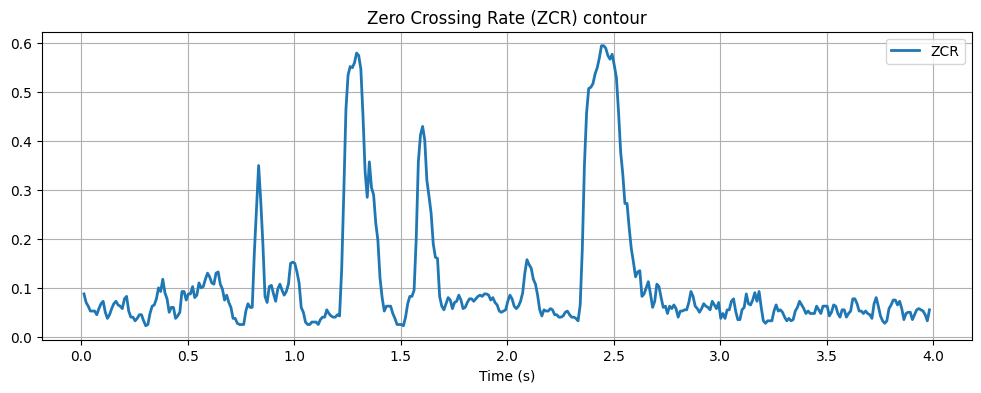

ZCR stats:
Silence: mean=6.0357e-02 | std=2.0373e-02 | min=2.2500e-02 | max=1.1750e-01
Voiced vowel: mean=8.9100e-02 | std=3.0991e-02 | min=2.5000e-02 | max=1.3250e-01
Unvoiced fricative: mean=2.7900e-01 | std=2.4545e-01 | min=3.2500e-02 | max=5.9500e-01


In [14]:
def zcr(frames, w=None, remove_mean=False):
    x = frames.copy()
    if remove_mean:
        x = x - np.mean(x, axis=1, keepdims=True)
    if w is not None:
        x = x * w[None, :]
    # sign changes
    s = np.sign(x)
    s[s == 0] = 1
    changes = np.abs(np.diff(s, axis=1))
    # each sign flip contributes 2
    return np.sum(changes, axis=1) / (2.0 * x.shape[1])

if "frames" in globals():
    Z = zcr(frames, w=w, remove_mean=False)
    tZ = frame_times(len(Z), N, H, fs)

    plt.figure(figsize=(12, 4))
    plt.plot(tZ, Z, linewidth=2.0, label="ZCR")
    plt.title("Zero Crossing Rate (ZCR) contour") 
    plt.xlabel("Time (s)")
    plt.legend()
    plt.show()

    print("ZCR stats:")
    region_stats(tZ, Z, regions)

---
## 7) ZCR and noise: create synthetic noise and compare
We’ll generate a noise segment and compare its ZCR to speech.


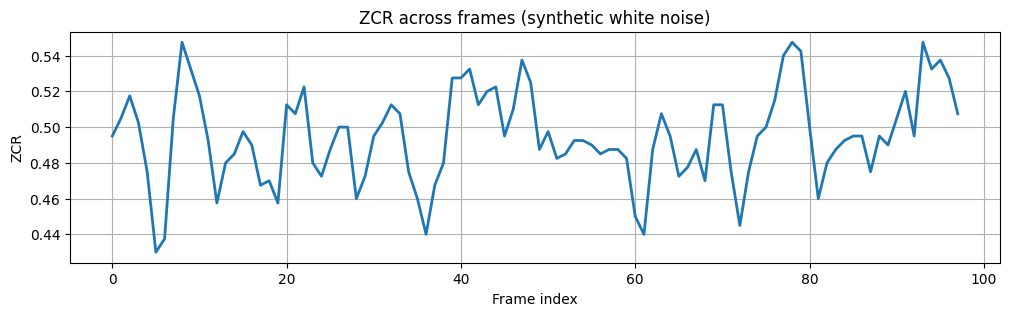

Noise ZCR: mean= 0.4947704076766968 std= 0.02569713443517685


In [15]:
# Create a short noise signal and compute ZCR on it
fsN = fs if "x" in globals() else 16000
dur = 1.0
noise = 0.1 * np.random.randn(int(dur*fsN)).astype(np.float32)

Nn = int(round(frame_ms * 1e-3 * fsN))
Hn = int(round(hop_ms   * 1e-3 * fsN))
wn = hamming_window(Nn)
frames_noise = frame_signal(noise, Nn, Hn)

Zn = zcr(frames_noise, w=wn, remove_mean=False)

plt.figure(figsize=(12, 3))
plt.plot(Zn, linewidth=2.0)
plt.title("ZCR across frames (synthetic white noise)")
plt.xlabel("Frame index")
plt.ylabel("ZCR")
plt.show()

print("Noise ZCR: mean=", float(np.mean(Zn)), "std=", float(np.std(Zn)))

---
## 8) Practical issue: DC offset can break ZCR
If the signal is shifted upward or downward (nonzero mean), ZCR can drop.

We will:
1. Take one frame
2. Add a DC offset
3. Compare ZCR before/after
4. Fix using mean removal


ZCR (original, no mean removal): 0.05
ZCR (DC offset, no mean removal): 0.0
ZCR (original, mean removed): 0.055
ZCR (DC offset, mean removed): 0.055


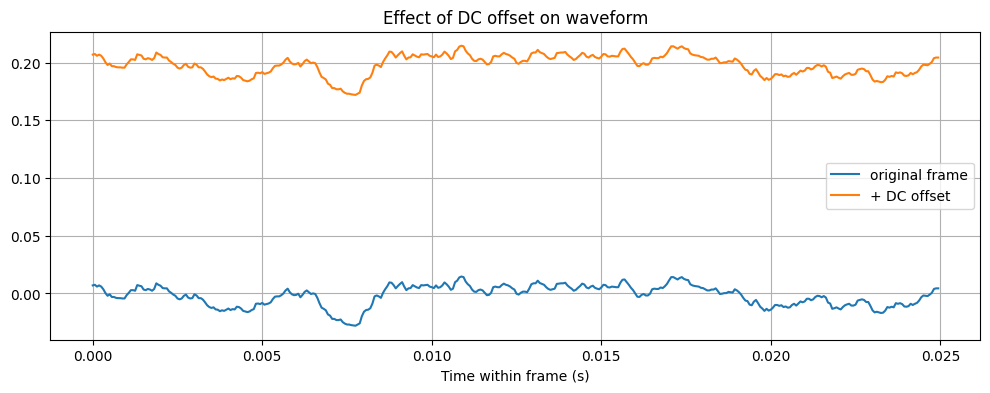

In [16]:
if "frames" in globals():
    m = 10
    f = frames[m].copy()
    f_dc = f + 0.2  # DC offset

    # Create single-frame "batch" for our zcr() function
    F = np.stack([f, f_dc], axis=0)

    z_raw = zcr(F, w=None, remove_mean=False)
    z_fix = zcr(F, w=None, remove_mean=True)

    print("ZCR (original, no mean removal):", z_raw[0])
    print("ZCR (DC offset, no mean removal):", z_raw[1])
    print("ZCR (original, mean removed):", z_fix[0])
    print("ZCR (DC offset, mean removed):", z_fix[1])

    # Visualize the waveforms
    t = np.arange(len(f)) / fs
    plt.figure(figsize=(12, 4))
    plt.plot(t, f, label="original frame")
    plt.plot(t, f_dc, label="+ DC offset")
    plt.title("Effect of DC offset on waveform")
    plt.xlabel("Time within frame (s)")
    plt.legend()
    plt.show()

---
## 9) Combine Energy + ZCR for quick interpretation
Energy and ZCR together often separate:
- silence (low E)
- voiced (high E, low Z)
- unvoiced (moderate E, high Z)

We’ll plot (ZCR vs Energy) as a scatter plot.


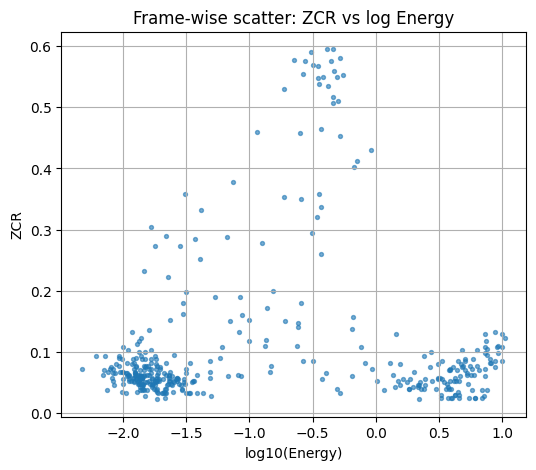

Try selecting different WAVs or recording types and see how clusters change.


In [17]:
if "frames" in globals():
    # Log-energy for better scale
    logE = np.log10(E + 1e-12)

    plt.figure(figsize=(6, 5))
    plt.scatter(logE, Z, s=8, alpha=0.6)
    plt.xlabel("log10(Energy)")
    plt.ylabel("ZCR")
    plt.title("Frame-wise scatter: ZCR vs log Energy")
    plt.grid(True)
    plt.show()

    print("Try selecting different WAVs or recording types and see how clusters change.")

---
## 10) Summary + what’s next

✅ You computed and interpreted:
- short-time energy
- short-time magnitude
- zero crossing rate (ZCR)

✅ You demonstrated real-world issues:
- noise increases ZCR
- DC offset can reduce ZCR, fixed by mean removal

➡️ Next: **Notebook 3 — Autocorrelation + Pitch + Voicing cues**

### Quick check (answer in a markdown cell)
1. Which feature is most reliable for **silence detection** in clean recordings?
2. Which feature is most useful for distinguishing **voiced vs unvoiced**?
3. Why do we often plot **log energy** instead of raw energy?


### Answers

1. Short time detection
2. Zero crossing rate
3. It allows better visualization for smaller changes.